In [1]:
import numpy as np
import pandas as pd
import io
import requests
import seaborn as sns
from matplotlib import pyplot as plt
import pickle
import os
from pandas.api.types import CategoricalDtype
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_score

In [2]:
columns = ["age", "workClass", "fnlwgt", "education", "education-num","marital-status", "occupation", "relationship",
          "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]

In [15]:
train_data = pd.read_csv('/MachineLearning-Python/adult.data', names=columns, sep=' *, *', na_values='?')


/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             9 non-null      object 
 1   workClass       0 non-null      float64
 2   fnlwgt          0 non-null      float64
 3   education       0 non-null      float64
 4   education-num   0 non-null      float64
 5   marital-status  0 non-null      float64
 6   occupation      0 non-null      float64
 7   relationship    0 non-null      float64
 8   race            0 non-null      float64
 9   sex             0 non-null      float64
 10  capital-gain    0 non-null      float64
 11  capital-loss    0 non-null      float64
 12  hours-per-week  0 non-null      float64
 13  native-country  0 non-null      float64
 14  income          0 non-null      float64
dtypes: float64(14), object(1)
memory usage: 1.2+ KB


In [10]:
test_data  = pd.read_csv('/MachineLearning-Python/adult.test', names=columns, sep=' *, *',skiprows=1, na_values='?')


/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             16281 non-null  int64 
 1   workClass       15318 non-null  object
 2   fnlwgt          16281 non-null  int64 
 3   education       16281 non-null  object
 4   education-num   16281 non-null  int64 
 5   marital-status  16281 non-null  object
 6   occupation      15315 non-null  object
 7   relationship    16281 non-null  object
 8   race            16281 non-null  object
 9   sex             16281 non-null  object
 10  capital-gain    16281 non-null  int64 
 11  capital-loss    16281 non-null  int64 
 12  hours-per-week  16281 non-null  int64 
 13  native-country  16007 non-null  object
 14  income          16281 non-null  object
dtypes: int64(6), object(9)
memory usage: 1.9+ MB


In [11]:
num_attributes = train_data.select_dtypes(include=['int'])
print(num_attributes.columns)

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1256fbfd0>,
      dtype=object)

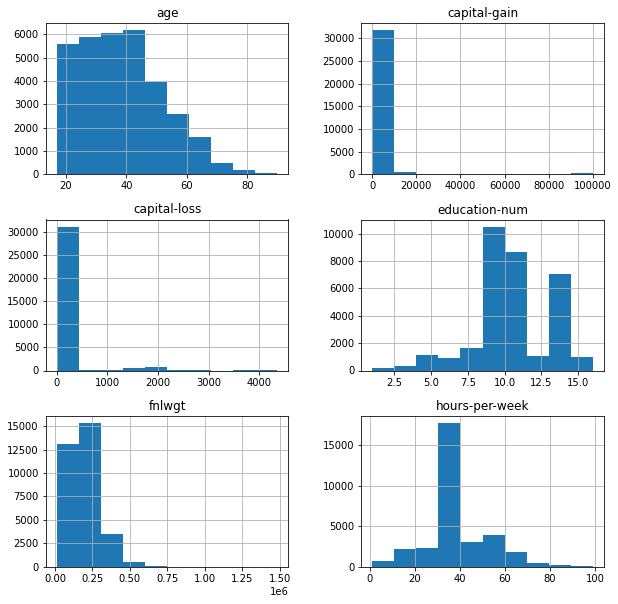

In [12]:
num_attributes.hist(figsize=(10,10))

In [14]:
train_data.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [16]:
cat_attributes = train_data.select_dtypes(include=['object'])
print(cat_attributes.columns)

Index(['workClass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country', 'income'],
      dtype='object')


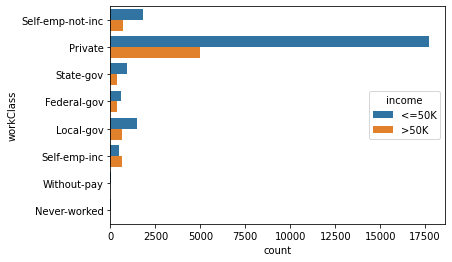

In [17]:
sns.countplot(y='workClass', hue='income', data = cat_attributes)

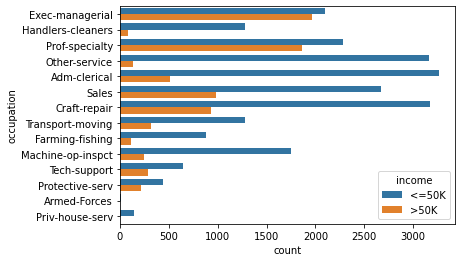

In [18]:
sns.countplot(y='occupation', hue='income', data = cat_attributes)

In [19]:
class ColumnsSelector(BaseEstimator, TransformerMixin):
  
  def __init__(self, type):
    self.type = type
  
  def fit(self, X, y=None):
    return self
  
  def transform(self,X):
    return X.select_dtypes(include=[self.type])

In [20]:
num_pipeline = Pipeline(steps=[
    ("num_attr_selector", ColumnsSelector(type='int')),
    ("scaler", StandardScaler())
])

In [21]:
class CategoricalImputer(BaseEstimator, TransformerMixin):
  
  def __init__(self, columns = None, strategy='most_frequent'):
    self.columns = columns
    self.strategy = strategy
    
    
  def fit(self,X, y=None):
    if self.columns is None:
      self.columns = X.columns
    
    if self.strategy is 'most_frequent':
      self.fill = {column: X[column].value_counts().index[0] for 
        column in self.columns}
    else:
      self.fill ={column: '0' for column in self.columns}
      
    return self
      
  def transform(self,X):
    X_copy = X.copy()
    for column in self.columns:
      X_copy[column] = X_copy[column].fillna(self.fill[column])
    return X_copy

In [23]:
class CategoricalEncoder(BaseEstimator, TransformerMixin):
  
  def __init__(self, dropFirst=True):
    self.categories=dict()
    self.dropFirst=dropFirst
    
  def fit(self, X, y=None):
    join_df = pd.concat([train_data, test_data])
    join_df = join_df.select_dtypes(include=['object'])
    for column in join_df.columns:
      self.categories[column] = join_df[column].value_counts().index.tolist()
    return self
    
  def transform(self, X):
    X_copy = X.copy()
    X_copy = X_copy.select_dtypes(include=['object'])
    for column in X_copy.columns:
      X_copy[column] = X_copy[column].astype({column:
                CategoricalDtype(self.categories[column])})
    return pd.get_dummies(X_copy, drop_first=self.dropFirst)

In [24]:
cat_pipeline = Pipeline(steps=[
    ("cat_attr_selector", ColumnsSelector(type='object')),
    ("cat_imputer", CategoricalImputer(columns=
          ['workClass','occupation', 'native-country'])),
    ("encoder", CategoricalEncoder(dropFirst=True))
])

In [25]:
full_pipeline = FeatureUnion([("num_pipe", num_pipeline), 
                ("cat_pipeline", cat_pipeline)])

In [26]:
print(full_pipeline)

FeatureUnion(n_jobs=None,
             transformer_list=[('num_pipe',
                                Pipeline(memory=None,
                                         steps=[('num_attr_selector',
                                                 ColumnsSelector(type='int')),
                                                ('scaler',
                                                 StandardScaler(copy=True,
                                                                with_mean=True,
                                                                with_std=True))],
                                         verbose=False)),
                               ('cat_pipeline',
                                Pipeline(memory=None,
                                         steps=[('cat_attr_selector',
                                                 ColumnsSelector(type='object')),
                                                ('cat_imputer',
                                                 Catego

In [27]:
train_data.drop(['fnlwgt', 'education'], axis=1, inplace=True)
test_data.drop(['fnlwgt', 'education'], axis=1, inplace=True)

Training the model

In [28]:
train_copy = train_data.copy()
train_copy["income"] = train_copy["income"].apply(lambda x:0 if 
                        x=='<=50K' else 1)
X_train = train_copy.drop('income', axis =1)
Y_train = train_copy['income']

In [29]:
print(X_train)
print(Y_train)

       age         workClass  education-num      marital-status  \
0       50  Self-emp-not-inc             13  Married-civ-spouse   
1       38           Private              9            Divorced   
2       53           Private              7  Married-civ-spouse   
3       28           Private             13  Married-civ-spouse   
4       37           Private             14  Married-civ-spouse   
...    ...               ...            ...                 ...   
32555   27           Private             12  Married-civ-spouse   
32556   40           Private              9  Married-civ-spouse   
32557   58           Private              9             Widowed   
32558   22           Private              9       Never-married   
32559   52      Self-emp-inc              9  Married-civ-spouse   

              occupation   relationship   race     sex  capital-gain  \
0        Exec-managerial        Husband  White    Male             0   
1      Handlers-cleaners  Not-in-family  White    M

In [30]:
X_train_processed=full_pipeline.fit_transform(X_train)
model = LogisticRegression(random_state=0)
model.fit(X_train_processed, Y_train)

/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Testing the model

In [31]:
test_copy = test_data.copy()
test_copy["income"] = test_copy["income"].apply(lambda x:0 if 
                      x=='<=50K.' else 1)
X_test = test_copy.drop('income', axis =1)
Y_test = test_copy['income']

In [32]:
X_test_processed = full_pipeline.fit_transform(X_test)
predicted_classes = model.predict(X_test_processed)

In [33]:
accuracy_score(predicted_classes, Y_test.values)

0.8522727272727273

Text(33.0, 0.5, 'Actual classes')

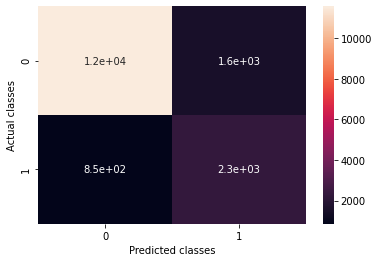

In [35]:
cfm = confusion_matrix(predicted_classes, Y_test.values)
sns.heatmap(cfm, annot=True)
plt.xlabel('Predicted classes')
plt.ylabel('Actual classes')

Cross-Validation

In [36]:
cross_val_model = LogisticRegression(random_state=0)
scores = cross_val_score(cross_val_model, X_train_processed, 
         Y_train, cv=5)
print(np.mean(scores))

/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit

0.8508599508599509


/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fine Tuning the model :GridSearchCV 

In [37]:
# penalty specifies the norm in the penalization
penalty = ['l1', 'l2']
# C is the inverese of regularization parameter
C = np.logspace(0, 4, 10)
random_state=[0]
# creating a dictionary of hyperparameters
hyperparameters = dict(C=C, penalty=penalty, 
                  random_state=random_state)

In [38]:
clf = GridSearchCV(estimator = model, param_grid = hyperparameters, 
                   cv=5)
best_model = clf.fit(X_train_processed, Y_train)
print('Best Penalty:', best_model.best_estimator_.get_params() ['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/sklearn/linear_model/_l

/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit

/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit

/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit

Best Penalty: l2
Best C: 1.0


/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [39]:
best_predicted_values = best_model.predict(X_test_processed)
accuracy_score(best_predicted_values, Y_test.values)

0.8522727272727273

Saving the model

In [40]:
filename = 'LG_final_model.sav'
pickle.dump(model, open(filename, 'wb'))

Loading the model from the pickle

In [41]:
saved_model = pickle.load(open(filename, 'rb')) 